In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import re
from statsmodels.formula.api import ols

In [32]:
# from os import listdir
# from os.path import isfile, join
# files = [f for f in listdir('data') if isfile(join('data', f))]
# df = pd.concat([pd.read_csv('data/'+f) for f in files])

In [78]:
df = pd.read_csv('data.csv')

### Clean raw data

In [79]:
def strtolistc(val):
    """Convert string to list of floats"""
    ls = val.strip('[]').split(',')
    new = []
    for v in ls:
        new.append(float(v))
    return(np.array(new))

In [93]:
df['d_heuristics'] = df['d_heuristics'].apply(strtolistc)
df['x_heuristics'] = df['x_heuristics'].apply(strtolistc)
df['d_set'] = df['d_heuristics'].map(lambda x: set(x))
df['x_set'] = df['x_heuristics'].map(lambda x: set(x))
df['d_cover'] = df['d_set'].map(lambda x: len(x))
df['x_cover'] = df['x_set'].map(lambda x: len(x))

"""Diversity trumps ability"""
df['dta'] = df['diverse'] > df['expert'] # Frequency
df['dta'] = df['dta'].map(lambda x: int(x))

df['diff'] = df['diverse'] - df['expert'] # Diff mean score

### Check cover diversity

<AxesSubplot:>

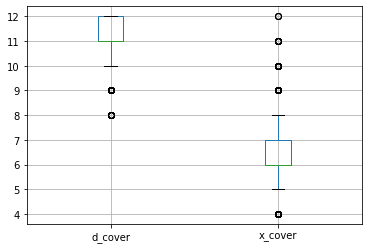

In [89]:
df.boxplot(column=['d_cover', 'x_cover'])

### Plot "diveristy trumps ability" frequency

In [90]:
sigma = 12
dta = df[(df['sigma']==sigma)][['dta', 'trust', 'smoothness']].groupby(['trust', 'smoothness'])['dta'].sum().to_frame().unstack()
dta = dta['dta']
count = df[(df['sigma']==sigma)][['dta', 'trust', 'smoothness']].groupby(['trust', 'smoothness'])['dta'].count().to_frame().unstack()
count = count['dta']
dta = dta/count

([<matplotlib.axis.XTick at 0x124c60550>,
 [Text(0, 0, 'none'),
  Text(1, 0, 'low'),
  Text(2, 0, 'moderate'),
  Text(3, 0, 'high')])

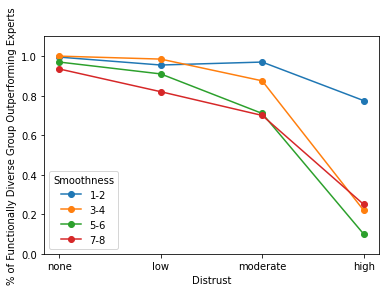

In [91]:
fig, ax = plt.subplots()
for i in range(1, 9, 2):
    data = list((dta[i]+dta[i+1])/2)
    data.reverse()
    ax.plot(data, label=str(i)+'-'+str(i+1), marker='o')
    ax.set_ylim(0, 1.1)
plt.xlabel('Distrust')
plt.ylabel('% of Functionally Diverse Group Outperforming Experts')
plt.legend(title='Smoothness')
plt.xticks((0, 1, 2, 3), ['none', 'low', 'moderate', 'high'])

# plt.savefig('../graphs/freq12.png', dpi=350, bbox_inches='tight')

### Plot difference in mean score

In [87]:
diff = df[(df['sigma']==sigma)][['diff', 'trust', 'smoothness']].groupby(['trust', 'smoothness'])['diff'].mean().to_frame().unstack()
diff = diff['diff']

([<matplotlib.axis.XTick at 0x124f39910>,
 [Text(0, 0, 'none'),
  Text(1, 0, 'low'),
  Text(2, 0, 'moderate'),
  Text(3, 0, 'high')])

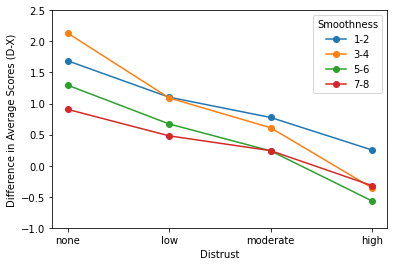

In [94]:
fig, ax = plt.subplots()
for i in range(1, 9, 2):
    data = list((diff[i]+diff[i+1])/2)
    data.reverse()
    ax.plot(data, label=str(i)+'-'+str(i+1), marker='o')
    ax.set_ylim(-1, 2.5)
plt.xlabel('Distrust')
plt.ylabel('Difference in Average Scores (D-X)')
plt.legend(title='Smoothness')
plt.xticks((0, 1, 2, 3), ['none', 'low', 'moderate', 'high'])

# plt.savefig('../graphs/diff12.png', dpi=350, bbox_inches='tight')